# Custom Models and Training with TensorFlow

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Tensors and operations

### Tensors

In [2]:
tf.constant([[1., 2., 3.], [4., 5., 6.]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [3]:
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [4]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t.shape

TensorShape([2, 3])

In [5]:
t.dtype

tf.float32

## Indexing

In [6]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [7]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

## Ops

In [8]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [9]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [10]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

In [11]:
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

## From/To Numpy

In [12]:
a = np.array([2., 4., 5.])  # 默认情况下Numpy使用64位精度，而TensorFlow使用32精度
tf.constant(a)  # TensorFlow不会自动执行任何类型转换，操作数原来是什么精度类型，完成转换后就是什么类型

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [13]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [14]:
tf.square(a)  # 将TensorFlow操作应用于Numpy数组

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [15]:
np.square(t)  # 将Numpy操作应用于张量

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

## Conflicting Types

In [16]:
tf.constant(2.) + tf.constant(40)

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]

In [17]:
tf.constant(2.) + tf.constant(40., dtype=tf.float64)

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]

In [18]:
t2 = tf.constant(40., dtype=tf.float64)

In [19]:
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

## Strings

In [20]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [21]:
tf.constant("café")  # 使用Unicode字符串创建字符串张量，则它将自动被编码为UTF-8

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [22]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

In [23]:
b = tf.strings.unicode_encode(u, "UTF-8")
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [24]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

## String arrays

In [25]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [26]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2], dtype=int32)>

In [27]:
r = tf.strings.unicode_decode(p, "UTF-8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>

In [28]:
print(r)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>


## Ragged Tensors

In [29]:
print(r[1])

tf.Tensor([ 67 111 102 102 101 101], shape=(6,), dtype=int32)


In [30]:
print(r[1:3])

<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>


In [31]:
r2 = tf.ragged.constant([[65, 66], [], [67]])

In [32]:
print(tf.concat([r, r2], axis=0))

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>


In [33]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71], [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


In [34]:
tf.strings.unicode_encode(r3, "UTF-8")

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'DEF', b'G', b'', b'HI'], dtype=object)>

In [35]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]], dtype=int32)>

## Sparse Tensor

In [36]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]], values=[1., 2., 3.], dense_shape=[3, 4])

In [37]:
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [38]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [39]:
s2 = s * 2.0

In [40]:
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [41]:
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [42]:
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]], values=[1., 2.], dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [43]:
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

indices[1] = [0,1] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense]


In [44]:
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

## Sets

In [45]:
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sparse.to_dense(tf.sets.union(set1, set2))

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]], dtype=int32)>

In [46]:
tf.sparse.to_dense(tf.sets.difference(set1, set2))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]], dtype=int32)>

In [47]:
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]], dtype=int32)>

## Variables

In [48]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [49]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [50]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [51]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [52]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


In [53]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [54]:
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]], indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

## Tensor Arrays

In [55]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [56]:
array.read(1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

In [57]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [58]:
mean, variance = tf.nn.moments(array.stack(), axes=0)
mean

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>

In [59]:
variance

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.6666665, 8.666667 ], dtype=float32)>

## Custom loss function

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [60]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, 
                                                              housing.target.reshape(-1, 1),
                                                             random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)
X_test_scaled = scaler.fit_transform(X_test)

In [61]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)  # 如果是小损失，取squared_loss，否则取linear_loss

In [62]:
help(tf.where)

Help on function where_v2 in module tensorflow.python.ops.array_ops:

where_v2(condition, x=None, y=None, name=None)
    Return the elements where `condition` is `True` (multiplexing `x` and `y`).
    
    This operator has two modes: in one mode both `x` and `y` are provided, in
    another mode neither are provided. `condition` is always expected to be a
    `tf.Tensor` of type `bool`.
    
    #### Retrieving indices of `True` elements
    
    If `x` and `y` are not provided (both are None):
    
    `tf.where` will return the indices of `condition` that are `True`, in
    the form of a 2-D tensor with shape (n, d).
    (Where n is the number of matching indices in `condition`,
    and d is the number of dimensions in `condition`).
    
    Indices are output in row-major order.
    
    >>> tf.where([True, False, False, True])
    <tf.Tensor: shape=(2, 1), dtype=int64, numpy=
    array([[0],
           [3]])>
    
    >>> tf.where([[True, False], [False, True]])
    <tf.Tensor: sh

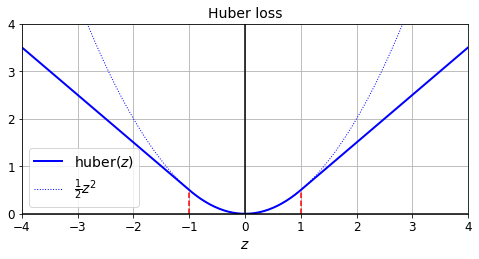

In [63]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [64]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1)
])

In [65]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [66]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 0.5493 - mae: 0.9044 - val_loss: 0.2334 - val_mae: 0.5369
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2164 - mae: 0.5115 - val_loss: 0.2168 - val_mae: 0.5169


## Saving/Loading Models with Custom Objects

In [67]:
model.save("my_model_with_a_custom_loss.h5")

In [68]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5", 
                                custom_objects={"huber_fn": huber_fn})

In [69]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2058 - mean_absolute_error: 0.4980 - val_loss: 0.2109 - val_mean_absolute_error: 0.5105
Epoch 2/2
363/363 [==============================] - 0s 988us/step - loss: 0.1990 - mean_absolute_error: 0.4888 - val_loss: 0.2082 - val_mean_absolute_error: 0.5042


In [70]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_error = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_error, linear_loss)
    return huber_fn

In [71]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [72]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2209 - mae: 0.4883 - val_loss: 0.2373 - val_mae: 0.5176
Epoch 2/2
363/363 [==============================] - 0s 994us/step - loss: 0.2163 - mae: 0.4830 - val_loss: 0.2338 - val_mae: 0.5044


In [73]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [74]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                               custom_objects={"huber_fn": create_huber(2.0)})

In [75]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2126 - mean_absolute_error: 0.4784 - val_loss: 0.2327 - val_mean_absolute_error: 0.5072
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2116 - mean_absolute_error: 0.4759 - val_loss: 0.2262 - val_mean_absolute_error: 0.5014


In [76]:
model.loss.__code__.co_freevars

('threshold',)

In [77]:
model.loss.__closure__[0].cell_contents

2.0

In [78]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [79]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1)
])

In [80]:
model.compile(loss=HuberLoss(2.0), optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 0.8221 - mae: 0.9790 - val_loss: 0.2673 - val_mae: 0.5367
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2406 - mae: 0.5040 - val_loss: 0.2430 - val_mae: 0.5273


In [81]:
model.save("my_model_with_a_custom_loss_class.h5")

In [82]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5", 
                                custom_objects={"HuberLoss": HuberLoss})

In [83]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2268 - mean_absolute_error: 0.4930 - val_loss: 0.2427 - val_mean_absolute_error: 0.5308
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2220 - mean_absolute_error: 0.4886 - val_loss: 0.2375 - val_mean_absolute_error: 0.5128


In [84]:
model.loss.threshold

2.0

## Other Custom Functions

In [85]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [86]:
def my_softplus(z):  # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)


def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)


def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))


def my_positive_weights(weights):  # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [87]:
layer = keras.layers.Dense(30, activation=my_softplus, kernel_initializer=my_glorot_initializer, 
                          kernel_regularizer=my_l1_regularizer, kernel_constraint=my_positive_weights)

In [88]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal", 
                      input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus, kernel_regularizer=my_l1_regularizer, 
                      kernel_constraint=my_positive_weights, kernel_initializer=my_glorot_initializer)
])

In [89]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [90]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 0.7688 - val_mae: 0.5641
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 0.6298 - val_mae: 0.5331


In [91]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [92]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [93]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [94]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [95]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 0.7688 - val_mae: 0.5641
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 0.6298 - val_mae: 0.5331


In [96]:
model.save("my_model_with_many_custom_parts.h5")

In [97]:
model = keras.models.load_model("my_model_with_many_custom_parts.h5", 
                                custom_objects={
                                    "MyL1Regularizer": MyL1Regularizer,
                                    "my_positive_weights": my_positive_weights,
                                    "my_glorot_initializer": my_glorot_initializer,
                                    "my_softplus": my_softplus
                                })

## Custom Metrics

In [98]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [99]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [100]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [101]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 0s 840us/step - loss: 2.0982 - huber_fn: 0.9192
Epoch 2/2
363/363 [==============================] - 0s 823us/step - loss: 0.6052 - huber_fn: 0.2733


## Streaming Metrics (逐批次更新的流式指标)

In [102]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [103]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [104]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [105]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [106]:
precision.reset_states()

In [107]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [108]:
class HuberMetric(keras.metrics.Metric):  # Streaming Metrics
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)  # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), dtype=tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [109]:
m = HuberMetric(2.0)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14

m(tf.constant([[2.]]), tf.constant([[10.]]))  
# 当你使用此类的实例作为函数时（像我们对Precision的对象所做的那样），将调用update_state()方法

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [110]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [111]:
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [112]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [113]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

Let's check that the HuberMetric class works well:

In [114]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [115]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1)
])

In [116]:
model.compile(loss=create_huber(2.), optimizer="nadam", metrics=[HuberMetric(2.)])

In [117]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 0s 859us/step - loss: 0.8707 - huber_metric: 0.8707
Epoch 2/2
363/363 [==============================] - 0s 785us/step - loss: 0.2595 - huber_metric: 0.2595


In [118]:
model.save("my_model_with_a_custom_metric.h5")

In [119]:
model = keras.models.load_model("my_model_with_a_custom_metric.h5", 
                                custom_objects={"huber_fn": create_huber(2.0),  # 对应第一个自定义损失函数对象
                                                "HuberMetric": HuberMetric})

In [120]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 0s 782us/step - loss: 0.2350 - huber_metric: 0.2350
Epoch 2/2
363/363 [==============================] - 0s 781us/step - loss: 0.2278 - huber_metric: 0.2278


In [121]:
model.metrics[-1].threshold

2.0

Looks like it works fine! More simply, we could have created the class like this:

In [122]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name="HuberMetric", dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

This class handles shapes better, and it also supports sample weights.

In [123]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [124]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1)
])

In [125]:
model.compile(loss=keras.losses.Huber(2.), optimizer="nadam", weighted_metrics=[HuberMetric(2.)])

In [126]:
sample_weight = np.random.rand(len(y_train))

history = model.fit(X_train_scaled.astype(np.float32), 
                    y_train.astype(np.float32), epochs=2, 
                    sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 0s 965us/step - loss: 0.4455 - HuberMetric: 0.8978
Epoch 2/2
363/363 [==============================] - 0s 977us/step - loss: 0.1305 - HuberMetric: 0.2631


In [127]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.44554364681243896, 0.44554368685750223)

In [128]:
model.save("my_model_with_a_custom_metric_v2.h5")

In [129]:
model = keras.models.load_model("my_model_with_a_custom_metric_v2.h5",
                                custom_objects={"HuberMetric": HuberMetric})

In [130]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 0s 990us/step - loss: 0.2377 - HuberMetric: 0.2377
Epoch 2/2
363/363 [==============================] - 0s 987us/step - loss: 0.2279 - HuberMetric: 0.2279


In [131]:
model.metrics[-1].threshold

2.0

## Custom Layers

In [132]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [133]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(name="kernel", shape=[batch_input_shape[-1], self.units], 
                                      initializer="glorot_normal")
        self.bias = self.add_weight(name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape)  # must be at the end
        
    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units, 
                "activation": keras.activations.serialize(self.activation)}

In [134]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [135]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [136]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 2.2563 - val_loss: 0.8027
Epoch 2/2
363/363 [==============================] - 0s 897us/step - loss: 0.6485 - val_loss: 0.6134


In [137]:
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 378us/step - loss: 0.5474


0.5474219918251038

In [138]:
model.save("my_model_with_a_custom_layer.h5")

In [139]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5", custom_objects={"MyDense": MyDense})

In [140]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return [X1 + X2, X1 * X2, X1 / X2]
    
    def compute_output_shape(self, batch_input_shape):
        b1, b2 = batch_input_shape
        return [b1, b1, b1]

In [141]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2, outputs3= MyMultiLayer()((inputs1, inputs2))

Let's create a layer with a different behavior during training and testing:

In [142]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [143]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [144]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    AddGaussianNoise(0.1),
    MyDense(1)
])

In [145]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 2.2689 - val_loss: 0.8044
Epoch 2/2
363/363 [==============================] - 0s 895us/step - loss: 0.6695 - val_loss: 0.6164


In [146]:
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 447us/step - loss: 0.5500


0.5500037670135498

In [147]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_dense (MyDense)           (None, 30)                270       
_________________________________________________________________
add_gaussian_noise (AddGauss (None, 30)                0         
_________________________________________________________________
my_dense_1 (MyDense)         (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


## Custom Models

In [148]:
X_new_scaled = X_test_scaled

In [149]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu", 
                                          kernel_initializer="he_normal") for _ in range(n_layers)]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [150]:
class ResidualRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)
        
    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [151]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [152]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 9.1325
Epoch 2/5
363/363 [==============================] - 1s 1ms/step - loss: 1.0578
Epoch 3/5
363/363 [==============================] - 1s 1ms/step - loss: 0.8868
Epoch 4/5
363/363 [==============================] - 1s 1ms/step - loss: 0.5834
Epoch 5/5
363/363 [==============================] - 1s 1ms/step - loss: 0.6457


In [153]:
score = model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 488us/step - loss: 0.8621


In [154]:
model.save("my_custom_model.ckpt")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_custom_model.ckpt/assets


In [155]:
model = keras.models.load_model("my_custom_model.ckpt")

In [156]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 0.8009
Epoch 2/5
363/363 [==============================] - 1s 1ms/step - loss: 0.5385
Epoch 3/5
363/363 [==============================] - 1s 1ms/step - loss: 0.4804
Epoch 4/5
363/363 [==============================] - 1s 1ms/step - loss: 0.4956
Epoch 5/5
363/363 [==============================] - 1s 1ms/step - loss: 0.5031


We could have defined the model using the sequential API instead:

In [157]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [158]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [159]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 0s 1ms/step - loss: 0.8695
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4720
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5537
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.3809
Epoch 5/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4012


In [160]:
score = model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 426us/step - loss: 0.7041


In [161]:
y_pred = model.predict(X_new_scaled)

## Losses and Metrics Based on Model Internals

In [162]:
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))  # 基于模型内部的自定义损失
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)  # 基于模型内部的自定义指标
            self.add_metric(result)
        return self.out(Z)

In [163]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [164]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)  # 注意, tensorflow 2.3.1在这里会抛出异常

Epoch 1/2


InaccessibleTensorError: in user code:

    /home/coco/ml/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/coco/ml/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/coco/ml/env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/coco/ml/env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/coco/ml/env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/coco/ml/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/coco/ml/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /home/coco/ml/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:230 __call__
        reg_loss = math_ops.add_n(regularization_losses)
    /home/coco/ml/env/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/coco/ml/env/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:3511 add_n
        return gen_math_ops.add_n(inputs, name=name)
    /home/coco/ml/env/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:431 add_n
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/coco/ml/env/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/coco/ml/env/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:589 _create_op_internal
        inp = self.capture(inp)
    /home/coco/ml/env/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:634 capture
        raise errors.InaccessibleTensorError(

    InaccessibleTensorError: The tensor 'Tensor("mul:0", shape=(), dtype=float32)' cannot be accessed here: it is defined in another function or code block. Use return values, explicit Python locals or TensorFlow collections to access it. Defined in: FuncGraph(name=build_graph, id=139655631254864); accessed from: FuncGraph(name=train_function, id=139655631281168).
    


Epoch 1/2

363/363 [==============================] - 0s 1ms/step - loss: 0.6951 - reconstruction_error: 5.0000

Epoch 2/2

363/363 [==============================] - 0s 1ms/step - loss: 0.3920 - reconstruction_error: 5.0000

Train on 11610 samples

Epoch 1/2

11610/11610 [==============================] - 1s 98us/sample - loss: 0.7647

Epoch 2/2

11610/11610 [==============================] - 0s 40us/sample - loss: 0.4112

## Computing Gradients with Autodiff

In [165]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [166]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [167]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [168]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)
    
gradients = tape.gradient(z, [w1, w2])

In [169]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [170]:
with tf.GradientTape() as tape:
    z = f(w1, w2)
    
dz_w1 = tape.gradient(z, w1)

In [171]:
dz_w1

<tf.Tensor: shape=(), dtype=float32, numpy=36.0>

In [172]:
try:
    dz_w2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

GradientTape.gradient can only be called once on non-persistent tapes.


In [173]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)
    
dz_w1 = tape.gradient(z, w1)
dz_w2 = tape.gradient(z, w2)

In [174]:
dz_w1

<tf.Tensor: shape=(), dtype=float32, numpy=36.0>

In [175]:
dz_w2

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [176]:
del tape

In [177]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)
    
gradients = tape.gradient(z, [c1, c2])

In [178]:
gradients

[None, None]

In [179]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)
    
gradients = tape.gradient(z, [c1, c2])

In [180]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [181]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)
    
tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [182]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([136.,  30.], dtype=float32)>

In [183]:
del tape

In [184]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
    
hessians = [hessian_tape.gradient(jacobian, [w1, w2]) for jacobian in jacobians]
del hessian_tape

In [185]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [186]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [187]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)


with tf.GradientTape() as tape:
    z = f(w1, w2)
    
gradients = tape.gradient(z, [w1, w2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [188]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

In [189]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [190]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)
    
tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [191]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [192]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [193]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

## Custom Training Cycle

In [194]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [195]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [196]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [197]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result()) for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics, end=end)

In [198]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


A fancier version with a progress bar:

In [199]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [200]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [201]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [202]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [203]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [204]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)  # 主损失加其他损失（在此模型中，每层都有一个正则化损失）
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)  # 更新平均损失
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11610/11610 [==============================] - mean: 1.3955 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 [==============================] - mean: 0.6774 - mean_absolute_error: 0.5280
Epoch 3/5
11610/11610 [==============================] - mean: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 [==============================] - mean: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 [==============================] - mean: 0.6440 - mean_absolute_error: 0.5222


In [205]:
try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

## TensorFlow Functions and Graph

In [206]:
def cube(x):
    return x ** 3

In [207]:
cube(2)

8

In [208]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [209]:
tf_cube = tf.function(cube)
tf_cube

In [210]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [211]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [212]:
@tf.function
def tf_cube(x):
    return x ** 3

In [213]:
tf_cube.python_function(2)

8

### TF Functions and Concrete Functions

In [214]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph

In [215]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [216]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### Exploring Function Definitions and Graphs

In [217]:
concrete_function.graph

In [218]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [219]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [220]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [221]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [222]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [223]:
concrete_function.function_def.signature

name: "__inference_tf_cube_997689"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}